Stage 03 — Python Fundamentals (Self-Contained Notebook-as-Script)

This single file solves the assignment end-to-end.  
You can:
- **Run it as a script**: `python hw03_python_fundamentals.py`
- **Or open in Jupyter/VS Code**: the `%%` cells act like notebook cells.

What it does:

1) NumPy operations + loop vs vectorization timing
2) Load dataset from `data/starter_data.csv` (or auto-generate if missing)
3) Inspect with `.info()` / `.head()`
4) Summary stats via `.describe()`
5) Groupby aggregation by `category` (if present)
6) Save outputs to `data/processed/summary.csv` & `summary.json`
7) Plot a simple figure to `figures/basic_plot.png`
8) Define and use a reusable `get_summary_stats` function

In [1]:
from __future__ import annotations
from pathlib import Path
import timeit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [19]:

# Project paths
CWD = Path.cwd()
PROJECT_ROOT = CWD.parent / "turtle_project"

DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
FIG_DIR = PROJECT_ROOT / "figures"

for p in [DATA_DIR, PROCESSED_DIR, FIG_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("Project root:", PROJECT_ROOT)
print("Data dir:", DATA_DIR)
print("Processed dir:", PROCESSED_DIR)
print("Figures dir:", FIG_DIR)




Project root: /Users/panweihu/Desktop/Desktop_m1/NYU_mfe/bootcamp/camp4/bootcamp_bill_panwei_hu/turtle_project
Data dir: /Users/panweihu/Desktop/Desktop_m1/NYU_mfe/bootcamp/camp4/bootcamp_bill_panwei_hu/turtle_project/data
Processed dir: /Users/panweihu/Desktop/Desktop_m1/NYU_mfe/bootcamp/camp4/bootcamp_bill_panwei_hu/turtle_project/data/processed
Figures dir: /Users/panweihu/Desktop/Desktop_m1/NYU_mfe/bootcamp/camp4/bootcamp_bill_panwei_hu/turtle_project/figures


## Numpy operations

In [3]:

# NumPy operations
arr = np.arange(1, 100_001, dtype=float)  # 1..100000
arr_sq = arr ** 2
arr_scaled = 0.5 * arr + 3

print("First 5 of arr:", arr[:5])
print("First 5 of arr_sq:", arr_sq[:5])
print("First 5 of arr_scaled:", arr_scaled[:5])

First 5 of arr: [1. 2. 3. 4. 5.]
First 5 of arr_sq: [ 1.  4.  9. 16. 25.]
First 5 of arr_scaled: [3.5 4.  4.5 5.  5.5]


## Compare loop vs vectorize solution

In [4]:
# Timing
setup_code = """
import numpy as np
arr = np.arange(1, 100_001, dtype=float)
"""
loop_stmt = """
out = []
for x in arr:
    out.append(0.5 * x + 3)
"""
vector_stmt = """
out = 0.5 * arr + 3
"""
loop_time = timeit.timeit(loop_stmt, setup=setup_code, number=5)
vec_time  = timeit.timeit(vector_stmt, setup=setup_code, number=5)
print(f"Loop time (5 runs):      {loop_time:.4f}s")
print(f"Vectorized time (5 runs): {vec_time:.4f}s")
if vec_time > 0:
    print(f"Approx speedup: {loop_time/vec_time:.1f}x")



Loop time (5 runs):      0.7090s
Vectorized time (5 runs): 0.0016s
Approx speedup: 442.4x


## Loading data

In [20]:

# Load dataset
csv_path = DATA_DIR / "starter_data.csv"
if not csv_path.exists():
    rng = np.random.default_rng(42)
    n = 200
    df_syn = pd.DataFrame({
        "id": np.arange(1, n + 1),
        "category": rng.choice(list("ABC"), size=n, p=[0.4, 0.35, 0.25]),
        "value": rng.normal(loc=10.0, scale=2.5, size=n).round(3),
        "value2": rng.normal(loc=50.0, scale=10.0, size=n).round(3),
        "date": pd.date_range("2023-01-01", periods=n, freq="D"),
    })
    df_syn.to_csv(csv_path, index=False)
    print(f"Generated synthetic dataset at: {csv_path}")

df = pd.read_csv(csv_path, parse_dates=["date"], dayfirst=False)
print("Using dataset:", csv_path)
display(df.head())


Using dataset: /Users/panweihu/Desktop/Desktop_m1/NYU_mfe/bootcamp/camp4/bootcamp_bill_panwei_hu/turtle_project/data/starter_data.csv


,category,value,date
0,A,10,2025-08-01
1,B,15,2025-08-02
2,A,12,2025-08-03
3,B,18,2025-08-04
4,C,25,2025-08-05


In [21]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   category  10 non-null     object        
 1   value     10 non-null     int64         
 2   date      10 non-null     datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 368.0+ bytes


,count,mean,std,min,25%,50%,75%,max
value,10.0,17.6,7.381659,10.0,12.25,14.5,23.25,30.0


Groupby mean by 'category':


,value
category,
A,11.500000
B,15.666667
C,27.666667


Saved: /Users/panweihu/Desktop/Desktop_m1/NYU_mfe/bootcamp/camp4/bootcamp_bill_panwei_hu/turtle_project/data/processed/summary.csv
Saved: /Users/panweihu/Desktop/Desktop_m1/NYU_mfe/bootcamp/camp4/bootcamp_bill_panwei_hu/turtle_project/data/processed/summary.json


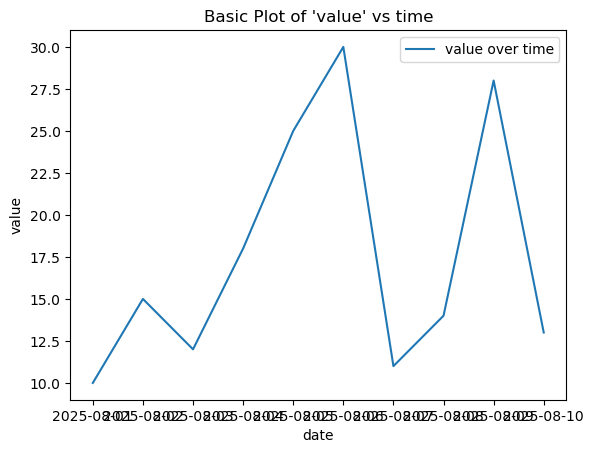

Saved figure: /Users/panweihu/Desktop/Desktop_m1/NYU_mfe/bootcamp/camp4/bootcamp_bill_panwei_hu/turtle_project/figures/basic_plot.png


In [22]:
# Summary statistics
numeric_desc = df.select_dtypes(include="number").describe().T
display(numeric_desc)

# Groupby
if "category" in df.columns:
    group_stats = df.groupby("category").mean(numeric_only=True)
    print("Groupby mean by 'category':")
    display(group_stats)
else:
    print("No 'category' column found; skipping groupby example.")
    group_stats = None

# Save outputs
summary_csv = PROCESSED_DIR / "summary.csv"
summary_json = PROCESSED_DIR / "summary.json"
numeric_desc.to_csv(summary_csv)
numeric_desc.to_json(summary_json, orient="table")
print("Saved:", summary_csv)
print("Saved:", summary_json)

# Plot
if "date" in df.columns and "value" in df.columns:
    df_sorted = df.sort_values("date")
    plt.figure()
    plt.plot(df_sorted["date"], df_sorted["value"], label="value over time")
    plt.xlabel("date")
    plt.ylabel("value")
    plt.title("Basic Plot of 'value' vs time")
    plt.legend()
    fig_path = FIG_DIR / "basic_plot.png"
    plt.savefig(fig_path, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved figure:", fig_path)
else:
    print("Missing 'date' or 'value' columns; skipping plot.")


In [23]:
# Function
def get_summary_stats(df: pd.DataFrame, groupby_col: str | None = None) -> dict:
    desc = df.select_dtypes(include="number").describe().T
    grp = None
    if groupby_col and groupby_col in df.columns:
        grp = df.groupby(groupby_col).mean(numeric_only=True)
    return {"describe": desc, "groupby": grp}

res = get_summary_stats(df, groupby_col="category" if "category" in df.columns else None)
print("Reusable function — describe() head:")
display(res["describe"].head())
if res["groupby"] is not None:
    print("Reusable function — groupby means:")
    display(res["groupby"])


Reusable function — describe() head:


,count,mean,std,min,25%,50%,75%,max
value,10.0,17.6,7.381659,10.0,12.25,14.5,23.25,30.0


Reusable function — groupby means:


,value
category,
A,11.500000
B,15.666667
C,27.666667


## Importing functions from src/utils

In [24]:
import sys
from pathlib import Path

# Add ./project_name/src to sys.path
sys.path.append( PROJECT_ROOT / "src")
sys.path.insert(0, PROJECT_ROOT / "src")
print("Added to sys.path:", PROJECT_ROOT / "src")


Added to sys.path: /Users/panweihu/Desktop/Desktop_m1/NYU_mfe/bootcamp/camp4/bootcamp_bill_panwei_hu/turtle_project/src


In [25]:
sys.path.insert(0, str(Path.cwd().parent / "turtle_project"))

In [26]:
from src.utils import get_summary_stats

# Example usage
import pandas as pd
df = pd.DataFrame({"a": [1, 2, 3]})
print(get_summary_stats(df))

{'describe':    count  mean  std  min  25%  50%  75%  max
a    3.0   2.0  1.0  1.0  1.5  2.0  2.5  3.0, 'groupby': None}
